## Установка зависимостей 

In [1]:
# !pip install -r requirements3.txt

## Блок импорта

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Постановка задачи 

Решаем жесткую тему - построение нейросети с нуля, без всяких там pytorch. Только numpy, только хардкор и знание базы глубокого обучения.

Строить мы будем простую генеративную соревновательную сеть (Generative Adversarial Network, GAN), которая будет выполнять простую задачу - генерировать кусочек функции y = sin(x) небольшого размера (базово в 10 точек, ниже это параметр X_DIM). Генерировать она его будет, конечно, из рандома.

Как и положено хорошему GANу, сеть будет состоять из двух отдельных подсетей - генератора и дискриминатора. Генератор будет генерировать последовательности из случайного шума, а дискриминатор - оценивать работу генератора путем сравнения ее с реальными образцами синусов, которые мы будем вычислять **строго**, так что они идеальны. И после оценки штрафовать генератор отдельной функцией потерь. Чтобы он, блин, запомнил!

## Базовые параметры обучения

In [3]:
# размерность входа генератора - 1. Одно случайное число. Нейронов в скрытом слое - 10.
Z_DIM = 1
G_HIDDEN = 10
# размерность входа дискриминатора - 10. Последовательность точек из якобы функции y = sin(x). Нейронов в скрытом слое - тоже 10.
X_DIM = 10
D_HIDDEN = 10

# скорости обучения для генератора и дискриминатора.
step_size_G = 0.01
step_size_D = 0.01

# число эпох обучения - будем щедры! но не слишком, так как переобучить такую сеть легко, 
# тормозов нет, и ReLU-нейроны вырубаются только в путь. Тут это важно, так как нейронов мало.
ITER_NUM = 50000

Так как у нас тут не pytorch, следить за весами-градиентами некому, и все будет написано ручками; а также по причине нестабильности обучения GANов - мы подстрахуем себя и выставим клиппинг (обрезку) градиентов и весов на вот такие значения:

In [4]:
GRADIENT_CLIP = 0.2
WEIGHT_CLIP = 0.25

## Функция генерации образцов синусов 

Обычно при обучении GANов берут сеты готовых картинок или промптов, но у нас задача математическая, так шта мы просто будем вычислять нужные нам десятиточечные массивы из функции y=sin(x) (а точнее, классическая гармоническая функция с фазой, амплитудой и циклической частотой y = A*sin(wx + phi)) по формуле.

In [5]:
# пространство истинных сигналов по формуле A*sin(wx + phi)
# с амплитудой-фазой-частотой
def get_samples(random=True):
    if random:
        phi = np.random.uniform(0, 1)
        w = np.random.uniform(1.2, 1.5)
        A = np.random.uniform(0.5, 0.8)
    else:
        phi = 0
        w = 0.2
        A = 1
    signal = [A * np.sin(phi + w * i) for i in range(X_DIM)]
    return np.array(signal)

## Функции активации

Здесть тоже все ручками. Заметьте две вещи - во-первых, все функции активации векторные, чтобы вычисляться быстро и четко, без циклов; во-вторых, мы заранее задаем также и **производные** функций активации, давая себе задел на вычисление бэкпропа.

In [6]:
# ReLU с производной
def ReLU(x):
    return np.maximum(x, 0)

def dReLU(x):
    return 1

# Ее менее дырявый братец с ненулевой левой частью, наклон которой задается коэффициентом k
def LeakyReLU(x, k=0.2):
    return np.where(x >= 0, x, x * k)

def dLeakyReLU(x, k=0.2):
    return np.where(x >=0, 1., k)

# гиперболический тангенс. Заметьте - для вычисления производной берется рекуррентная формула. Так быстрее и проще, чем дифференцировать по чесноку
def Tanh(x):
    return np.tanh(x)

def dTanh(x):
    return 1. - Tanh(x) ** 2

# сигмоида. Производная тоже вычисляется рекуррентно!
def Sigmoid(x):
    return 1. / (1. + np.exp(-x))

def dSigmoid(x):
    return Sigmoid(x) * (1. - Sigmoid(x))

## Инициализация весов сетей

In [7]:
# инициализатор весов случайный, по размерности - аналог инициализации Хе
def weight_initializer(in_channels, out_channels):
    scale = np.sqrt(2. / (in_channels + out_channels))
    return np.random.uniform(-scale, scale, (in_channels, out_channels))

## Функция потерь

Чтобы не мудрить, берем простую двоичную перекрестную энтропию (BCE). Градиент для бэкпропа тоже пишем заранее.

In [8]:
class LossFunc(object):
    def __init__(self):
        self.logit = None
        self.label = None
        
    def forward(self, logit, label):
        # обрезка логита, чтобы он не шкалил вблизи краев
        logit[0,0] = np.clip(logit[0,0], 1e-7, 1 - 1e-7)
        self.logit = logit
        self.label = label
        # формула вычисления двоичной перекрестной энтропии
        return -(label * np.log(logit) + (1 - label) * np.log(1 - logit))
    
    def backward(self):
        # производная двоичной перекрестной по логиту, по сути, градиент
        return (1 - self.label) / (1 - self.logit) - self.label /self.logit

## Генераторная подсеть 

Следите внимательно, как устроен бэкпроп!

In [9]:
# веса (weights, w) и смещения (bias, b) задаются матрицами/векторами
class Generator(object):
    def __init__(self):
        # вход
        self.z = None
        # первый скрытый слой
        self.w1 = weight_initializer(Z_DIM, G_HIDDEN)
        self.b1 = weight_initializer(1, G_HIDDEN)
        self.x1 = None
        # второй скрытый слой
        self.w2 = weight_initializer(G_HIDDEN, G_HIDDEN)
        self.b2 = weight_initializer(1, G_HIDDEN)
        self.x2 = None
        # выход
        self.w3 = weight_initializer(G_HIDDEN, X_DIM)
        self.b3 = weight_initializer(1, X_DIM)
        self.x3 = None
        self.x = None
        
    def forward(self, inputs):
        # кладем инпут
        self.z = inputs.reshape(1, Z_DIM)
        # первый скрытый слой и активация ReLU
        self.x1 = self.z @ self.w1 + self.b1
        self.x1 = ReLU(self.x1)
        # второй скрытый слой и активация ReLU
        self.x2 = self.x1 @ self.w2 + self.b2
        self.x2 = ReLU(self.x2)
        # выходной слой и активация гиперболическим тангенсом
        self.x3 = self.x2 @ self.w3 + self.b3
        self.x = Tanh(self.x3)
        return self.x
    
    def backward(self, outputs):
        # ВЫХОДНОЙ СЛОЙ
        delta = outputs
        
        # ПЕРЕДАЕМ ГРАДИЕНТЫ НА ВТОРОЙ СЛОЙ   
        # Производная функции потерь по выходу
              
        delta *= dTanh(self.x)
        # Производная по весам выходного слоя
        d_w3 = self.x2.T @ delta
        # Производная по смещениям выходного слоя
        d_b3 = delta.copy()
        # Производная по выходу второго / входу выходного слоя
        delta = delta @ self.w3.T
        
        # ОБНОВЛЯЕМ ПАРАМЕТРЫ ВЫХОДНОГО СЛОЯ
        # Веса выходного слоя с обрезкой градиентов и весов
        if (np.linalg.norm(d_w3) > GRADIENT_CLIP):
            d_w3 = GRADIENT_CLIP / np.linalg.norm(d_w3) * d_w3
        self.w3 -= step_size_G * d_w3
        self.w3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w3))
        # Смещения выходного слоя
        self.b3 -= step_size_G * d_b3
        self.b3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b3))
        delta *= dReLU(self.x2)
        
        # ПЕРЕДАЕМ ГРАДИЕНТЫ НА ПЕРВЫЙ СЛОЙ 
        # Производная по весам второго слоя
        d_w2 = self.x1.T @ delta
        # Производная по смещениям второго слоя
        d_b2 = delta.copy()
        # Производная по входу второго / выходу первого слоя
        delta = delta @ self.w2.T
        
        # ОБНОВЛЯЕМ ПАРАМЕТРЫ ВТОРОГО СЛОЯ
        # Веса второго слоя с обрезкой градиентов и весов
        if (np.linalg.norm(d_w2) > GRADIENT_CLIP):
            d_w2 = GRADIENT_CLIP / np.linalg.norm(d_w2) * d_w2
        self.w2 -= step_size_G * d_w2
        self.w2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP,  self.w2))
        # Смещения второго слоя
        self.b2 -= step_size_G * d_b2
        self.b2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b2))
        delta *= dReLU(self.x1)
        
        # УПИРАЕМСЯ ГРАДИЕНТОМ В ИНПУТ
        # Производная по весам первого слоя
        d_w1 = self.z.T @ delta
        # Производная по смещениям первого слоя
        d_b1 = delta.copy()
        
        # ОБНОВЛЯЕМ ПАРАМЕТРЫ ПЕРВОГО СЛОЯ
        # Веса первого слоя с обрезкой градиентов и весов
        if (np.linalg.norm(d_w1) > GRADIENT_CLIP):
            d_w1 = GRADIENT_CLIP / np.linalg.norm(d_w1) * d_w1
        self.w1 -= step_size_G * d_w1
        self.w1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w1))
        # Смещения первого слоя
        self.b1 -= step_size_G * d_b1
        self.b1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b1))

## Дискриминаторная подсеть 

Здесь тоже внимательно следим за бэкпропом!

In [10]:
# веса и смещения задаются матрицами/векторами
class Discriminator(object):
    def __init__(self):
        # вход
        self.x = None
        # первый скрытый слой
        self.w1 = weight_initializer(X_DIM, D_HIDDEN)
        self.b1 = weight_initializer(1, D_HIDDEN)
        self.y1 = None
        # второй скрытый слой
        self.w2 = weight_initializer(D_HIDDEN, D_HIDDEN)
        self.b2 = weight_initializer(1, D_HIDDEN)
        self.y2 = None
        # выход
        self.w3 = weight_initializer(D_HIDDEN, 1)
        self.b3 = weight_initializer(1, 1)
        self.y3 = None
        self.y = None
        
    def forward(self, inputs):
        # кладем инпут
        self.x = inputs.reshape(1, X_DIM)
        # первый скрытый слой и активация LeakyReLU
        self.y1 = self.x @ self.w1 + self.b1
        self.y1 = LeakyReLU(self.y1)
        # второй скрытый слой и активация Leaky ReLU
        self.y2 = self.y1 @ self.w2 + self.b2
        self.y2 = LeakyReLU(self.y2)
        # выходной слой с активацией логистической функцией
        self.y3 = self.y2 @ self.w3 + self.b3
        self.y = Sigmoid(self.y3)
        return self.y
    
    def backward(self, outputs, apply_grads=True):
        # Выходной слой
        delta = outputs
        # Производная функции потерь по выходу
        delta *= dSigmoid(self.y)
        # Производная по весам выходного слоя
        d_w3 = self.y2.T @ delta
        # Производная по смещениям выходного слоя
        d_b3 = delta.copy()
        
        # ПЕРЕДАЕМ ГРАДИЕНТЫ НА ВТОРОЙ СЛОЙ        
        # Производная по выходу второго слоя
        delta = delta @ self.w3.T
        
        # ОБНОВЛЯЕМ ПАРАМЕТРЫ ВЫХОДНОГО СЛОЯ
        if apply_grads:
            # Веса второго слоя с обрезкой градиентов и весов
            if np.linalg.norm(d_w3) > GRADIENT_CLIP:
                d_w3 = GRADIENT_CLIP / np.linalg.norm(d_w3) * d_w3
            # ВНИМАНИЕ! ГРАДИЕНТНОЕ ВОСХОЖДЕНИЕ!!! Знак не -=, а +=
            self.w3 += step_size_D * d_w3
            self.w3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w3))
            # Смещения второго слоя с обрезкой весов
            # ВНИМАНИЕ! ГРАДИЕНТНОЕ ВОСХОЖДЕНИЕ!!! Знак не -=, а +=
            self.b3 += step_size_D * d_b3
            self.b3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b3))
        delta *= dLeakyReLU(self.y2)
        
        # ПЕРЕДАЕМ ГРАДИЕНТЫ НА ПЕРВЫЙ СЛОЙ
        # Производная по весам второго слоя
        d_w2 = self.y1.T @ delta
        # Производная по смещениям второго слоя
        d_b2 = delta.copy()
        # Производная по входам второго / выходам первого слоя
        delta = delta @ self.w2.T
        
        # ОБНОВЛЯЕМ ПАРАМЕТРЫ ВТОРОГО СЛОЯ
        if apply_grads:
            # Веса второго слоя с обрезкой градиентов и весов
            if np.linalg.norm(d_w2) > GRADIENT_CLIP:
                d_w2 = GRADIENT_CLIP / np.linalg.norm(d_w2) * d_w2
            # ВНИМАНИЕ! ГРАДИЕНТНОЕ ВОСХОЖДЕНИЕ!!! Знак не -=, а +=
            self.w2 += step_size_D * d_w2
            self.w2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w2))
            # Смещения второго слоя с обрезкой
            self.b2 += step_size_D * d_b2
            self.b2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b2))
        delta *= dLeakyReLU(self.y1)
        
        # УПИРАЕМСЯ ГРАДИЕНТОМ В ИНПУТ
        # Производная по весам первого слоя
        d_w1 = self.x.T @ delta
        # Производная по смещениям первого слоя
        d_b1 = delta.copy()
        # Производная по инпуту
        delta = delta @ self.w1.T
        
        # ОБНОВЛЯЕМ ПАРАМЕТРЫ ПЕРВОГО СЛОЯ
        if apply_grads:
            # Веса первого слоя с обрезкой градиентов и весов
            if np.linalg.norm(d_w1) > GRADIENT_CLIP:
                d_w1 = GRADIENT_CLIP / np.linalg.norm(d_w1) * d_w1
            # ВНИМАНИЕ! ГРАДИЕНТНОЕ ВОСХОЖДЕНИЕ! Знак не -=, а +=
            self.w1 += step_size_D * d_w1
            self.w1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w1))
            # Смещения первого слоя с обрезкой
            self.b1 += step_size_D * d_b1
            self.b1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b1))
        return delta

## Абу чение

In [11]:
# функция, делающая нам картинку. Берет обученный генератор и выдвливает из него заданное количество образцов
def pic_diff(gen, samples, rand=True):
    np.random.seed(np.random.randint(0,100))
    fakes = [gen.forward(nor)[0] for nor in np.random.random(size=samples)]
    reals = [get_samples(rand) for _ in range(samples)]
  
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
    ax1.set_title('Fakes')
    ax1.plot(pd.DataFrame(np.asarray(fakes).T))
    ax2.set_title('Reals')
    ax2.plot(pd.DataFrame(np.asarray(reals).T));

Создаем экземпляры наших классов генератора, дискриминатора и функции потерь. Также задаем метки классов real/fake.

In [12]:
G = Generator()
D = Discriminator()
criterion = LossFunc()

real_label = 1
fake_label = 0

Здесь будем хранить потери генератора, чтобы потом построить кривую обучения и посмотреть на нее.

In [13]:
gen_losses = []

### Цикл обучения

In [14]:
for itr in range(ITER_NUM):
    # Суем нормальные синусы в дискриминатор
    # Реальные синусы
    x_real = get_samples(True)
    # Пробег дискриминатора вперед
    y_real = D.forward(x_real)
    # Вычисляем потерь
    loss_D_r = criterion.forward(y_real, real_label)
    # Градиент потерь
    d_loss_D = criterion.backward()
    # Бэкпропагейшон и обновление весов дискриминатора
    D.backward(d_loss_D)
    
    # Суем фейки в дискриминатор
    # Затравка генератора
    z_noise = np.random.randn(Z_DIM)
    # Генерация фейка - пробег генератора вперед
    x_fake = G.forward(z_noise)
    # Пробег дискриминатора вперед
    y_fake = D.forward(x_fake)
    # Вычисляем потери на дискриминаторе
    loss_D_f = criterion.forward(y_fake, fake_label)
    # Градиент потерь на дискриминаторе
    d_loss_D = criterion.backward()
    # Бэкпропагэйшон и обновление весов дискриминатора
    D.backward(d_loss_D)
    
    # Обновляем генератор с помощью потерь на фейках
    # Получение отдачи фейка с дискриминатора
    y_fake_r = D.forward(x_fake)
    # Вычисление потерь
    loss_G = criterion.forward(y_fake_r, real_label)
    # Вычисление потери на дискриминаторе (!)
    d_loss_G = D.backward(loss_G, apply_grads=False)
    # Бэкпропагейшон и обновление весов генератора
    G.backward(d_loss_G)
    # Cуммарные потери за прогон - за реальные данные и за фейк
    loss_D = loss_D_r + loss_D_f
    if itr % 2500 == 0:
        print(f'Дискриминатор - реальные: {loss_D_r.item((0, 0)):.6f} | Дискриминатор - фейки: {loss_D_f.item((0,0)):.6f} | Генератор: {loss_G.item((0, 0)):.6f}')
        gen_losses.append([itr, loss_G.item((0,0))])

Дискриминатор - реальные: 0.338220 | Дискриминатор - фейки: 0.866450 | Генератор: 0.125332
Дискриминатор - реальные: 0.656499 | Дискриминатор - фейки: 0.961747 | Генератор: 0.108767
Дискриминатор - реальные: 0.416301 | Дискриминатор - фейки: 1.175232 | Генератор: 0.081481
Дискриминатор - реальные: 0.515676 | Дискриминатор - фейки: 1.256468 | Генератор: 0.072930
Дискриминатор - реальные: 0.380582 | Дискриминатор - фейки: 1.401328 | Генератор: 0.060649
Дискриминатор - реальные: 0.434822 | Дискриминатор - фейки: 1.287958 | Генератор: 0.070423
Дискриминатор - реальные: 0.340153 | Дискриминатор - фейки: 1.354790 | Генератор: 0.064580
Дискриминатор - реальные: 0.301709 | Дискриминатор - фейки: 1.353658 | Генератор: 0.064782
Дискриминатор - реальные: 0.400993 | Дискриминатор - фейки: 1.385466 | Генератор: 0.062088
Дискриминатор - реальные: 0.420846 | Дискриминатор - фейки: 1.159522 | Генератор: 0.082669
Дискриминатор - реальные: 0.314345 | Дискриминатор - фейки: 1.305946 | Генератор: 0.068375

## Кривая обучения генератора

C:\Users\Foresign\AppData\Local\Temp/ipykernel_8164/3352411853.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


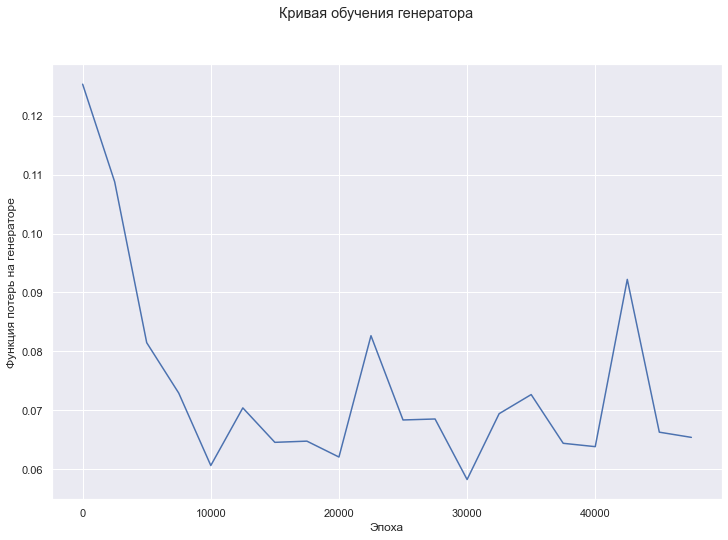

In [15]:
gen_losses = np.array(gen_losses)
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Кривая обучения генератора')
ax.set_xlabel('Эпоха')
ax.set_ylabel('Функция потерь на генераторе')
ax.plot(gen_losses[:, 0], gen_losses[:, 1])
fig.show();

Видите, как ее трясет? Это потому, что генератор обучается градиентным спуском, а дискриминатор - градиентным подъемом.
Мы не строили график, но посмотрите как потери дискриминатора на фейках РАСТУТ!

Стабильность обучения также жестко зависит от инициализации весов. У нас она рандомная, поэтому кочергу запустить получается не всегда.

Вода и камень, стихи и проза, лед и пламень. К сожалению, это фундаментальная проблема, поэтому стабильно обучить GAN не такая уж тривиальная задача. Но чому бы и нi?

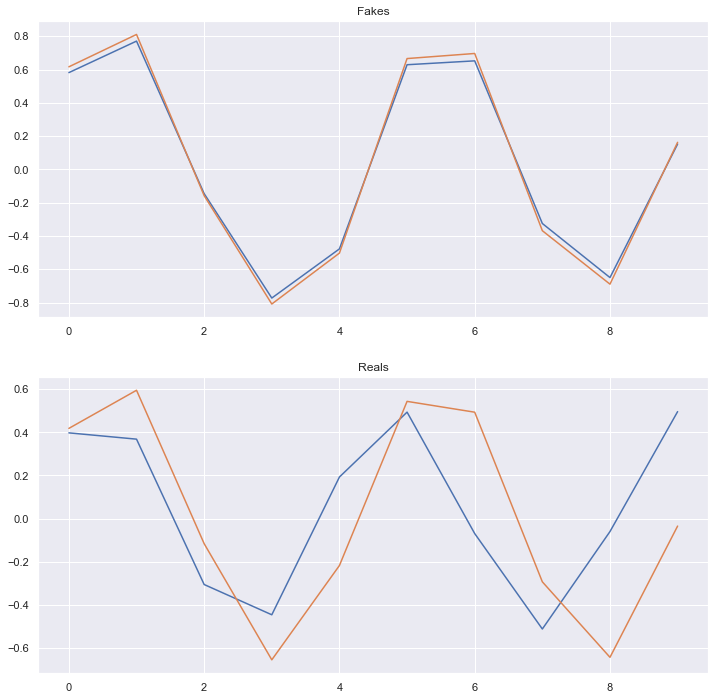

In [16]:
# Сравним сгенерированные образцы с реальными на глазок
pic_diff(G, samples=2)

Сгенерированные фейки имеют себе вполне синусный периодический вид; то, что реальные образцы разъехались - задано тем, что функция генерации задает им случайную фазу. Так или иначе, мы победили!